<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [2]:
#pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [3]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

CPython 3.5.2
IPython 4.2.0

numpy 1.12.1
scipy 0.19.0
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-72-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [3]:
!vw --version

8.3.2


##  1.1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [68]:
class SGDRegressor(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        _X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        
        # for epochs
        min_err = 1e10
        
        w = np.zeros(_X.shape[1])
        for i in range(self.n_iter):          
            # for each sample
            for j in range(_X.shape[0]):
                y_pred = np.dot(_X[j,:], w)
                upd = self.eta * (y[j] - y_pred)
                
                w[0] = w[0] + upd
                w[1] = w[1] + upd * _X[j,-1]
           
                w_copy = np.copy(w)
                self.weights_.append(w_copy)
                
                err = self.__mse(w_copy, _X, y)
                if err < min_err:
                    min_err = err
                    self.w_ = w_copy
                    
                self.mse_.append(err)
            
        return self
    
    def __mse(self, w, X, y):
        return np.sum(np.square(y - np.dot(X, w))) / float(len(y))
    
    def predict(self, X):
        _X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return np.dot(_X, self.w_)

In [13]:
len(np.array([1, 2]))

2

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [15]:
data_demo = pd.read_csv('../../data/weights_heights.csv')

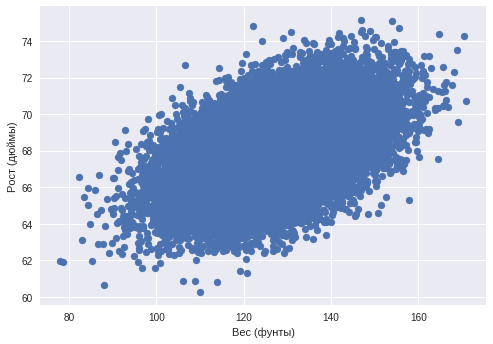

In [16]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [17]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [65]:
''' ВАШ КОД ЗДЕСЬ '''
regressor = SGDRegressor().fit(X_train_scaled, y_train)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

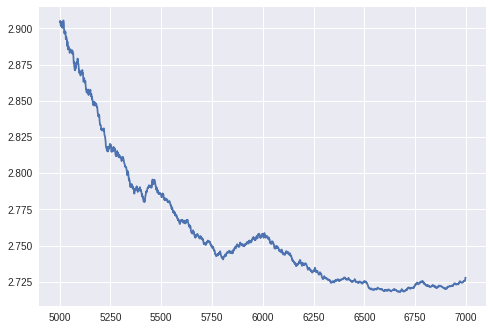

In [33]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(range(5000, 7000), regressor.mse_[5000:7000])

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [44]:
''' ВАШ КОД ЗДЕСЬ '''
print (regressor.weights_[np.argmin(regressor.mse_)] - regressor.w_)
print (np.min(regressor.mse_))
print (regressor.weights_[np.argmin(regressor.mse_)])

[ 0.  0.]
2.71513524066
[ 67.9898497    0.94447605]


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

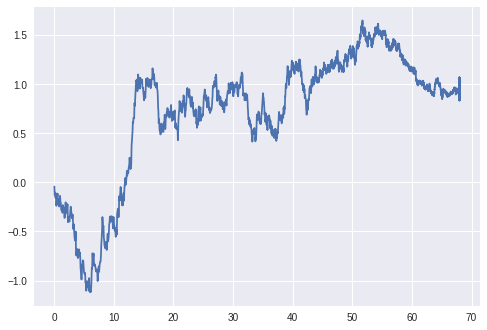

In [58]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(np.array(regressor.weights_)[:,0], np.array(regressor.weights_)[:,1])

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [67]:
''' ВАШ КОД ЗДЕСЬ '''
mean_squared_error(y_valid, regressor.predict(X_valid_scaled))

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [63]:
''' ВАШ КОД ЗДЕСЬ '''
from sklearn.linear_model import LinearRegression 
mean_squared_error(y_valid, LinearRegression().fit(X_train_scaled, y_train).predict(X_valid_scaled))

2.6708307676676348

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - **5**

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - ** * ** $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [69]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [324]:
class SGDClassifier(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    def __init__(self, eta=1e-3, n_iter=10, C=1):
        self.C = C
        self.eta = eta
        self.n_iter = n_iter
        
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        _X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        
        # for epochs
        min_loss = 1e10
        
        w = np.zeros(_X.shape[1])
        for i in range(self.n_iter):          
            
            # for each sample
            for j in range(_X.shape[0]):
            
                # for each feature                
                for d in range(_X.shape[1]):
                    wtx = np.dot(w.T, _X[j,:])
                    sigma_ywtx = sigma(-y[j] * wtx)

                    grad = self.C * y[j] * _X[j, d] * sigma_ywtx
                    regularizer = 0 if d == 0 else w[d]
                    w[d] = w[d] + self.eta * (grad - regularizer)

                w_copy = np.copy(w)
                self.weights_.append(w_copy)

                err = self.__loss(w_copy, _X, y)
                if err < min_loss:
                    min_loss = err
                    self.w_ = w_copy

                self.loss_.append(err)
        
        return self
    
    def __loss(self, w, X, y):
        return log_loss(y, sigma(np.dot(X, w)))
        
    def predict_proba(self, X):
        _X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return sigma(np.dot(_X, self.w_))

    def predict(self, X):
        return [-1 if result < 0.5 else 1 for result in self.predict_proba(X)]

 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [76]:
from sklearn.datasets import load_breast_cancer

In [77]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [220]:
''' ВАШ КОД ЗДЕСЬ '''
classifier = SGDClassifier(n_iter=3).fit(X_train_scaled, y_train)

In [222]:
print (np.min(classifier.loss_))
print (np.argmin(classifier.loss_))
print (classifier.w_ - classifier.weights_[np.argmin(classifier.loss_)])

0.314360184273
1193
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [180]:
import sklearn.linear_model as lm
etalon_classifier = lm.SGDClassifier(n_iter=3, loss='log', alpha=1, shuffle=False, eta0=1e-3, learning_rate='constant', l1_ratio=0)
etalon_classifier.fit(X_train_scaled, y_train)

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.001, fit_intercept=True, l1_ratio=0,
       learning_rate='constant', loss='log', n_iter=3, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=False,
       verbose=0, warm_start=False)

In [175]:
log_loss(etalon_classifier.predict(X_train_scaled), y_train)

1.7356369946545624

Постройте график изменения log_loss.

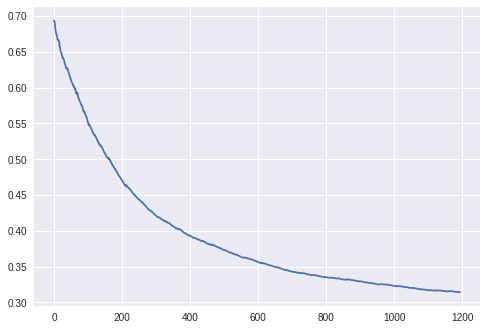

In [221]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(range(X_train_scaled.shape[0] * 3), classifier.loss_)

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [325]:
''' ВАШ КОД ЗДЕСЬ '''
classifier2 = SGDClassifier(C=1000, n_iter=10).fit(X_train_scaled, y_train)

In [326]:
np.min(classifier2.loss_)

0.044527279367025087

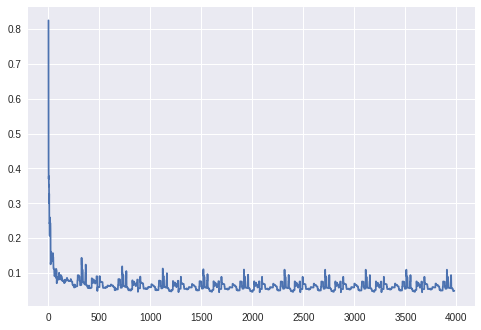

In [327]:
plt.plot(range(X_train_scaled.shape[0] * 10), classifier2.loss_)

In [ ]:
etalon_classifier = lm.SGDClassifier(n_iter=10, loss='log', shuffle=False, eta0=1e-3, learning_rate='constant', l1_ratio=0)
etalon_classifier.fit(X_train_scaled, y_train)

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - **compactness error**
 - worst fractal dimension

In [328]:
''' ВАШ КОД ЗДЕСЬ '''
print (np.min(classifier2.w_[1:]))
print (np.max(classifier2.w_[1:]))
print (classifier2.w_[1:])

-2.08421013498
1.32342531189
[-1.50917107 -1.57556644 -0.43059179 -0.45005512 -0.37663785  0.86967596
 -1.0663747  -1.72947667  0.2802285   0.57840054 -2.08421013  0.17868365
 -0.65303768 -1.13010877  0.22581407  1.32342531 -0.45659454  0.3716823
  0.29395394  0.77769191 -1.0636801  -0.57537347 -0.94377568 -1.14362477
 -1.786849   -0.54389812 -1.6361436  -0.94790485 -0.68988425 -0.57623028]


In [329]:
np.argmax(classifier2.w_[1:])

15

In [331]:
print (cancer.feature_names[np.argmin(classifier2.w_[1:])])
print (cancer.feature_names[np.argmax(classifier2.w_[1:])])

radius error
compactness error


In [260]:
list(zip(cancer.feature_names, classifier2.w_[1:]))

[('mean radius', -1.6575531973741515),
 ('mean texture', -3.4138735534807672),
 ('mean perimeter', -1.4098222612879403),
 ('mean area', -1.664931345289405),
 ('mean smoothness', -0.17720257064139316),
 ('mean compactness', 1.9782699090761193),
 ('mean concavity', -3.5669096433766656),
 ('mean concave points', -3.5432757346363055),
 ('mean symmetry', 0.41850130370618632),
 ('mean fractal dimension', 2.8603495441984488),
 ('radius error', -4.5318187974228357),
 ('texture error', 2.7917743029419277),
 ('perimeter error', -2.575288607063138),
 ('area error', -3.1545840145111592),
 ('smoothness error', 0.60303196005922222),
 ('compactness error', 4.5350588374655265),
 ('concavity error', 0.29303787559271677),
 ('concave points error', 0.079666766481794937),
 ('symmetry error', -0.52020555453873341),
 ('fractal dimension error', 4.6606676990249802),
 ('worst radius', -2.9241860576067755),
 ('worst texture', -4.0515637077930649),
 ('worst perimeter', -1.639552194822806),
 ('worst area', -2.51

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [276]:
X_valid_scaled.shape

(171, 30)

In [332]:
''' ВАШ КОД ЗДЕСЬ '''
valid_predictions = classifier2.predict(X_valid_scaled)
print (log_loss(y_valid, valid_predictions))
print (roc_auc_score(y_valid, valid_predictions))

0.807938622058
0.97086438152


In [285]:
y_valid[5:10]
# valid_predictions[1]

[1, 1, -1, 1, -1]

In [333]:
lr = LogisticRegression(random_state=17)
lr_predictions = lr.fit(X_train_scaled, y_train).predict(X_valid_scaled)
print (log_loss(y_valid, lr_predictions))
print (roc_auc_score(y_valid, lr_predictions))

0.807943298066
0.967213114754


In [336]:
print (cancer.feature_names[np.argmin(lr.coef_)])
print (cancer.feature_names[np.argmax(lr.coef_)])
# lr.coef_

radius error
compactness error


## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [337]:
!pwd

/home/borowis/code/mlcourse_open/jupyter_notebooks/topic8_sgd_hashing_vowpal_wabbit


In [338]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.linear_model as lm

In [346]:
# поменяйте путь к файлу
reviews_train = load_files("../../data/imdb_reviews/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [347]:
reviews_test = load_files("../../data/imdb_reviews/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [348]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [349]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 46.1 s, sys: 7.92 s, total: 54 s
Wall time: 54.8 s


In [350]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [351]:
%%time
''' ВАШ КОД ЗДЕСЬ '''
lr1_3 = LogisticRegression(random_state=17)
lr1_3.fit(X_train, y_train)

CPU times: user 1min 19s, sys: 1.81 s, total: 1min 21s
Wall time: 1min 2s


Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - ** Изменяемый шаг градиентного спуска **
 - ** Реализован линейный SVM **
 - Реализована ранняя остановка во избежание переобучения
 - ** Есть распараллеливание по процессорам **
 - ** Можно обучать LASSO **
 - Поддерживается онлайн-обучение деревьев решений
 - ** Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному) **


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [356]:
%%time
''' ВАШ КОД ЗДЕСЬ '''
sgdlr1_3 = lm.SGDClassifier(loss='log', n_iter=100, random_state=17)
sgdlr1_3.fit(X_train, y_train)

CPU times: user 10.8 s, sys: 0 ns, total: 10.8 s
Wall time: 10.7 s


<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - ** 3 **
 - 4
 - 5

In [369]:
lr1_3.predict_proba(X_test)[:,1]

array([  8.33784375e-01,   1.22312048e-03,   9.34993707e-01, ...,
         6.57912229e-03,   6.21952243e-02,   3.62180663e-04])

In [371]:
print (roc_auc_score(y_test, lr1_3.predict_proba(X_test)[:,1]))
print (roc_auc_score(y_test, sgdlr1_3.predict_proba(X_test)[:,1]))

0.9582472128
0.9572894656


In [372]:
print (roc_auc_score(y_test, lr1_3.predict_proba(X_test)[:,0]))
print (roc_auc_score(y_test, sgdlr1_3.predict_proba(X_test)[:,0]))

0.0417527872
0.0427105344


In [373]:
print (roc_auc_score(y_test, lr1_3.predict(X_test)))
print (roc_auc_score(y_test, sgdlr1_3.predict(X_test)))

0.8964
0.89444
